# BERT를 활용한 단일 문장 분류 실습

> 작성자      
```
* 김성현 (bananaband657@gmail.com)  
1기 멘토
김바다 (qkek983@gmail.com)
박상희 (parksanghee0103@gmail.com)  
이정우 (jungwoo.l2.rs@gmail.com)
2기 멘토
박상희 (parksanghee0103@gmail.com)  
이정우 (jungwoo.l2.rs@gmail.com)
이녕우 (leenw2@gmail.com)
박채훈 (qkrcogns2222@gmail.com)
3, 4, 5기 멘토
이녕우 (leenw2@gmail.com)
박채훈 (qkrcogns2222@gmail.com)
```
[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.




이번 시간에는 BERT를 활용해, 단일 문장을 분류하는 task를 실습해보겠습니다.

In [2]:
# !pip install transformers
# !pip install datasets

In [1]:
import torch
import datasets
import sys

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# 사용가능한 dataset list 불러오기
dataset_list = datasets.list_datasets()

# dataset list 확인
for datas in dataset_list:
    if 'kor' in datas: # 좀 더 넓게 검색하려면 'kor' 대신 'ko'를 사용하면 되지만, 상관없는 데이터도 너무 많이 나옴
        print(datas)

kor_3i4k
kor_hate
kor_ner
kor_nli
kor_nlu
kor_qpair
kor_sae
kor_sarcasm
squad_kor_v1
squad_kor_v2
AI-it/korean-hate-speech
Jack0508/TED2020_kor
Jack0508/TED2020vi_kor
KETI-AIR/kor_corpora
KETI-AIR/korquad
huggingartists/max-korzh
kresnik/zeroth_korean
msarmi9/korean-english-multitarget-ted-talks-task
poperson1205/mrtydi-v1.1-korean-fixed
tomekkorbak/test
tomekkorbak/pile-curse-small
tomekkorbak/pile-curse-full_test
tomekkorbak/pile-debug
tomekkorbak/pile-curse-chunk-1
tomekkorbak/pile-curse-chunk-0
tomekkorbak/pile-curse-chunk-3
tomekkorbak/pile-curse-chunk-2
tomekkorbak/pile-curse-chunk-5
tomekkorbak/pile-curse-chunk-6
tomekkorbak/pile-curse-chunk-4
tomekkorbak/pile-curse-chunk-16
tomekkorbak/pile-curse-chunk-15
tomekkorbak/pile-curse-chunk-14
tomekkorbak/pile-curse-chunk-13
tomekkorbak/pile-curse-chunk-8
tomekkorbak/pile-curse-chunk-9
tomekkorbak/pile-curse-chunk-20
tomekkorbak/pile-curse-chunk-18
tomekkorbak/pile-curse-chunk-7
tomekkorbak/pile-curse-chunk-24
tomekkorbak/pile-curse-c

In [4]:
# nsmc 데이터 로드 - 네이버 공개 데이터
dataset = datasets.load_dataset('nsmc') # nsmc, hate, sarcasm

# 데이터셋 구조 확인
print(dataset)

Found cached dataset nsmc (/home/kingstar/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [5]:
import pandas as pd

In [6]:
# 필요한 데이터인 document와 label 정보만 pandas라이브러리 DataFrame 형식으로 변환
train_data = pd.DataFrame({"document":dataset['train']['document'], "label":dataset['train']['label'],})
test_data = pd.DataFrame({"document":dataset['test']['document'], "label":dataset['test']['label'],})

In [7]:
# 데이터셋 갯수 확인
print('학습 데이터셋 : {}'.format(len(train_data)))
print('테스트 데이터셋 : {}'.format(len(test_data)))

학습 데이터셋 : 150000
테스트 데이터셋 : 50000


In [8]:
# 데이터셋 내용 확인
train_data.sample(10)

,document,label
13550,마음이2만보구 1편은 안봤었는데완전 슬픔ㅜㅜ 마음아~~~~ㅠㅠ,1
76604,눈높은척하기는 잼있는건 잼있는거다,1
131631,첫 시작을 역시 뭉개 버리는구나,0
83406,SF영화의 최고봉ㅋ스타크래프트가 이 영화로 영감을 얻었을듯,1
106091,감동 . 재미 모든걸 완성시킨 로빈윌리엄스,1
134103,현실에서 저렇게 끈질기게 살아남는다는건 불가능하지만 재밌게 봤음. 브래드 렌프로 데...,1
119288,아름다운 가족 이야기였다,1
101298,아무리 하정우가 주연이라지만 내가 하정우를 좋아한다지만.. ㅋㅋㅋㅋ,0
11429,"쓰레기같은 한국수입사, 영화이름을 지어내내 어디다가 쿵푸허슬을",0
72885,난 영화를본게 아니야. 이병현의 근육을 봤을 뿐이지,0


In [9]:
test_data.sample(10)

,document,label
17823,헤더 랭건캠프를 보는 재미 정도. 슬래셔의 공식을 살리지 못함. 속편들이 더 나음.,0
43130,재미있게 보고갑니다.,1
22248,풍자와 해학이 절묘하게 잘 어우러진 걸작..,1
41957,역시 손현주는 대박 짱~~~친구들도 짱~~~,1
34779,뭘 말하려는진 알겠는데요... 화면이 참 후집디다. 중간에 아들한테 말하는 신현준 ...,0
38256,못난주인을 둔 시간에게 정말미안하다..,0
6237,출연진들 이미지 망치는 프로그램. 게다가 PD는 졸면서 만들었는지 재미도 없고 기분...,0
32832,"평소에 킬링타임용 영화만 추구했던 나인데, 영화 공자를 보게된 이후로 다소 슬로우한...",1
48880,덜 떨어진 기독교의 리더. 전두환 협력자,0
49652,그다지,0


In [10]:
# 데이터 중복을 제외한 갯수 확인
print("학습데이터 : ", train_data['document'].nunique(), " 라벨 : ", train_data['label'].nunique())
print("데스트 데이터 : ", test_data['document'].nunique(), " 라벨 : ", test_data['label'].nunique())

# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace= True)
test_data.drop_duplicates(subset=['document'], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

학습데이터 :  146183  라벨 :  2
데스트 데이터 :  49158  라벨 :  2
중복 제거 후 학습 데이터셋 : 146183
중복 제거 후 테스트 데이터셋 : 49158


In [11]:
import numpy as np

In [12]:
# null 데이터 제거
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('null 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('null 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

null 제거 후 학습 데이터셋 : 146182
null 제거 후 테스트 데이터셋 : 49157


In [13]:
print(train_data['document'][0])
print(train_data['label'][0])

아 더빙.. 진짜 짜증나네요 목소리
0


학습 문장 최대 길이 : 146
학습 문장의 평균 길이 : 35.981338331668745


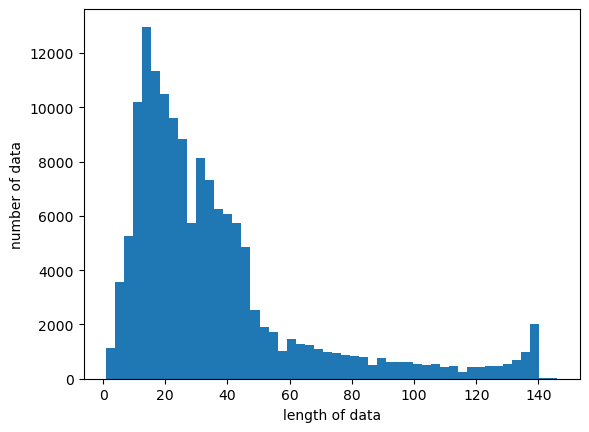

In [14]:
from matplotlib import pyplot as plt

#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in train_data['document']))
print('학습 문장의 평균 길이 :',sum(map(len, train_data['document']))/len(train_data['document']))

plt.hist([len(s) for s in train_data['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [15]:
# Store the model we want to use
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [16]:
tokenized_train_sentences = tokenizer(
    list(train_data['document']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [18]:
print(tokenized_train_sentences[0])
print()
print(tokenized_train_sentences[0].tokens)
print()
print(tokenized_train_sentences[0].ids)
print()
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=142, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [19]:
tokenized_test_sentences = tokenizer(
    list(test_data['document']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [20]:
train_label = train_data['label'].values
test_label = test_data['label'].values

In [28]:
print(train_label[:10])

[0 1 0 0 1 0 0 0 1 1]


In [29]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [30]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [31]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
# 문장 분류를 위해선 BERT 위에 classification을 위한 head를 부착해야 합니다.
# 해당 부분을 transformers에서는 라이브러리 하나만 호출하면 됩니다! :-)

In [32]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

In [33]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
trainer.train() # 1 epoch에 대략 30분 정도 소요됩니다 :-)

/home/kingstar/anaconda3/envs/ml2/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: traintogpb. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/tmp/ipykernel_2775/3162062469.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,0.552500
1000,0.435600
1500,0.399400
2000,0.387700
2500,0.369100
3000,0.348200
3500,0.347900
4000,0.329800
4500,0.322900


/tmp/ipykernel_2775/3162062469.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_2775/3162062469.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_2775/3162062469.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_2775/3162062469.py:7: UserWarning: To copy construct

TrainOutput(global_step=4569, training_loss=0.3872272581625204, metrics={'train_runtime': 1753.4759, 'train_samples_per_second': 83.367, 'train_steps_per_second': 2.606, 'total_flos': 1.066722312859032e+16, 'train_loss': 0.3872272581625204, 'epoch': 1.0})

In [35]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [37]:
trainer.evaluate(eval_dataset=test_dataset)

/tmp/ipykernel_2775/3162062469.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.3202677071094513,
 'eval_accuracy': 0.8597758203307769,
 'eval_f1': 0.8616169119270843,
 'eval_precision': 0.8549402390438247,
 'eval_recall': 0.8683986888430254,
 'eval_runtime': 164.525,
 'eval_samples_per_second': 298.781,
 'eval_steps_per_second': 4.674}

In [ ]:
# native training using torch

# model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

In [38]:
# predict함수
def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to(device)
    
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result

In [39]:
print(sentences_predict("영화 개재밌어 ㅋㅋㅋㅋㅋ"))
print(sentences_predict("진짜 재미없네요 ㅋㅋ"))
print(sentences_predict("너 때문에 진짜 짜증나"))
print(sentences_predict("정말 재밌고 좋았어요."))

1
0
0
1


In [ ]:
# pipeline 모듈을 사용하면 sentiment-analysis를 바로 prediction 가능
from transformers import pipeline

nlp_sentence_classif = pipeline('sentiment-analysis', tokenizer=tokenizer, device=0)

print(nlp_sentence_classif('영화 개재밌어 ㅋㅋㅋㅋㅋ'))
print(nlp_sentence_classif('진짜 재미없네요 ㅋㅋ',model= model))
print(nlp_sentence_classif('너 때문에 진짜 짜증나',model= model))
print(nlp_sentence_classif('정말 재밌고 좋았어요.',model= model))

끗!